# Analisis Data Eksploratif
Penelitian "PENERAPAN MACHINE LEARNING UNTUK ESTIMASI REMAINING USEFUL LIFE (RUL) ROLLER PADA TOP WEIGHTING ARM MESIN RING SPINNING (STUDI KASUS PT. XYZ)" - Hanindita Jati (2025)

In [1]:
# Import Libraries
import warnings
warnings.filterwarnings('ignore')
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import spearmanr

In [2]:
# Baca Data
data = pd.read_excel('DATAMODEL_2.xlsx', sheet_name='Sheet4x3') # pake data yg ada outlier jelas di excel
data = data.drop(columns=['ipi', 'ap']) # kolom rsf (udah bener tapi masi v1) dan ap belum bener, jadi diabaikan dulu
print(f'data.shape : {data.shape}\n')
print(data.info())
data.head(2)

data.shape : (447, 12)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 447 entries, 0 to 446
Data columns (total 12 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    447 non-null    datetime64[ns]
 1   RSF     447 non-null    object        
 2   ne      447 non-null    int64         
 3   u       447 non-null    float64       
 4   cvm     447 non-null    float64       
 5   cv1m    447 non-null    float64       
 6   thin    447 non-null    int64         
 7   thick   447 non-null    int64         
 8   neps    447 non-null    int64         
 9   ha      447 non-null    float64       
 10  D1      447 non-null    float64       
 11  D2      447 non-null    float64       
dtypes: datetime64[ns](1), float64(6), int64(4), object(1)
memory usage: 42.0+ KB
None


,Date,RSF,ne,u,cvm,cv1m,thin,thick,neps,ha,D1,D2
0,2024-02-01,1C,28,8.82,11.09,3.31,0,2,2,3.87,30.0,28.5
1,2024-02-01,1D,40,9.85,12.42,4.80,0,8,10,4.12,30.0,28.5


## Statistik Deskriptif

In [3]:
data.describe()

,Date,ne,u,cvm,cv1m,thin,thick,neps,ha,D1,D2
count,447,447.000000,447.00000,447.000000,447.000000,447.000000,447.000000,447.000000,447.000000,447.000000,447.000000
mean,2024-08-17 03:16:30.604026880,28.543624,9.07094,11.427740,3.750492,0.436242,3.498881,5.022371,4.339128,29.425839,28.158166
min,2024-02-01 00:00:00,20.000000,7.34000,9.240000,2.380000,0.000000,0.000000,0.000000,3.110000,28.600000,27.600000
25%,2024-05-03 00:00:00,24.000000,8.40000,10.575000,3.470000,0.000000,1.000000,2.000000,4.020000,29.175000,28.000000
50%,2024-08-13 00:00:00,30.000000,8.99000,11.300000,3.720000,0.000000,3.000000,4.000000,4.260000,29.400000,28.200000
75%,2024-11-18 00:00:00,30.000000,9.62500,12.110000,3.960000,0.000000,5.000000,7.000000,4.600000,29.800000,28.350000
max,2025-03-26 00:00:00,40.000000,11.16000,14.050000,8.300000,9.000000,19.000000,24.000000,6.090000,30.000000,28.800000
std,NaN,6.596796,0.86583,1.098623,0.485054,1.177073,3.199548,3.774999,0.433865,0.389763,0.251220


## Distribusi Data

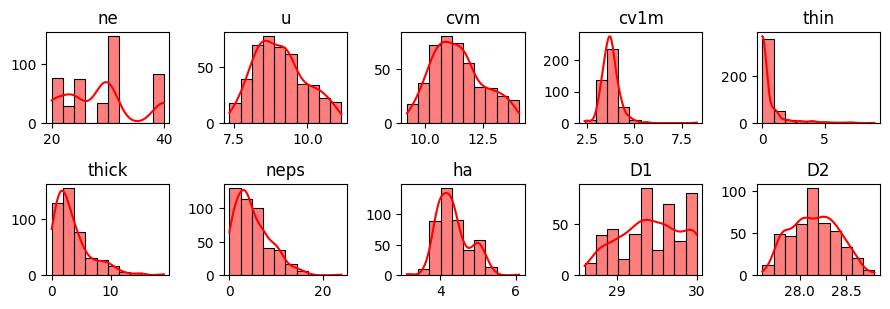

In [4]:
# Distribusi data_awal
fig, axes = plt.subplots(nrows=4, ncols=5, figsize=(9, 6))
axes = axes.flatten()

for i, col in enumerate(data.select_dtypes(include='number').columns):
    sns.histplot(data[col], kde=True, ax=axes[i], color='red', bins=10)
    axes[i].set_title(col)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')

for j in range(len(data.select_dtypes(include='number').columns), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

- Kolom u, cvm, ha distribusinya mendekati normal.
- Kolom lainnya menunjukkan distribusi yang skew dan acak.

## Periksa Outlier
Menggunakan IQR, karena metode berbasis mean dan standar deviasi seperti Z-score sangat rentan terhadap outlier, karena outlier dapat mempengaruhi mean dan SD secara signifikan. Mereka merekomendasikan metode berbasis median dan IQR sebagai alternatif yang lebih tahan terhadap pengaruh ekstrem.

- Leys, C., Ley, C., Klein, O., Bernard, P., & Licata, L. (2013).
"Detecting outliers: Do not use standard deviation around the mean, use absolute deviation around the median."
Journal of Experimental Social Psychology, 49(4), 764–766.
https://doi.org/10.1016/j.jesp.2013.03.013

In [5]:
def detect_outliers_iqr(df):
    outlier_summary = {}
    numeric_cols = df.select_dtypes(include='number').columns

    for col in numeric_cols:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1

        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
        outlier_count = outliers.shape[0]

        outlier_summary[col] = {
            "outlier_count": outlier_count,
            "lower_bound": lower_bound,
            "upper_bound": upper_bound
        }

    return pd.DataFrame(outlier_summary).T.sort_values(by='outlier_count', ascending=False)

Tukey menunjukkan bahwa batas bawah (Q1 - 1.5 * IQR) dan batas atas (Q3 + 1.5 * IQR) adalah metode sederhana dan kuat untuk mendeteksi outlier, terutama saat data tidak normal.
- Tukey, J. W. (1977).
"Exploratory Data Analysis."
Addison-Wesley.

Outlier per Kolom:
       outlier_count  lower_bound  upper_bound
thin            90.0       0.0000       0.0000
ne              84.0      15.0000      39.0000
cv1m            20.0       2.7350       4.6950
thick           11.0      -5.0000      11.0000
neps             9.0      -5.5000      14.5000
ha               2.0       3.1500       5.4700
u                0.0       6.5625      11.4625
cvm              0.0       8.2725      14.4125
D1               0.0      28.2375      30.7375
D2               0.0      27.4750      28.8750


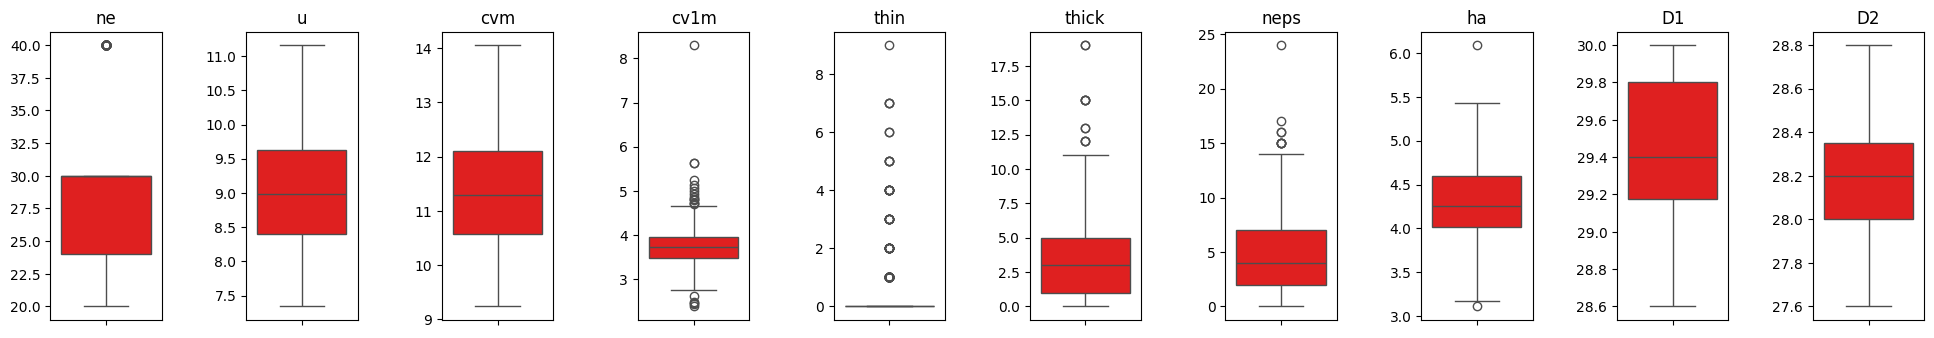

In [6]:
outlier_report = detect_outliers_iqr(data)
print("Outlier per Kolom:")
print(outlier_report)


num_cols = data.select_dtypes(include='number').columns
n_cols = len(num_cols)

fig, axes = plt.subplots(1, n_cols, figsize=(2*n_cols, 4))
fig.tight_layout(pad=3.0)

for i, col in enumerate(num_cols):
    sns.boxplot(y=data[col], ax=axes[i], color='red')
    axes[i].set_title(col)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')

plt.show()

Setelah dideteksi menggunakan IQR, terdapat outlier pada kolom ne, cv1m, thin, thick, neps, dan ha.
- Namun, kolom thin, thick, dan neps

## Korelasi (Spearman)

Korelasi Spearman digunakan karena memiliki performa yang lebih robust terhadap outlier dibanding Pearson, terutama saat data tidak berdistribusi normal (Hauke et al, 2011). Hal ini diperkuat dengan penelitian yang dilakukan Croux et al pada 2010 yang membandingkan langsung Pearson dengan Spearman, menyarankan penggunaan Spearman untuk data skewed dan tidak normal.

- Hauke, J., & Kossowski, T. (2011).
"Comparison of values of Pearson’s and Spearman’s correlation coefficients on the same sets of data."
Quaestiones Geographicae, 30(2), 87–93.
https://doi.org/10.2478/v10117-011-0021-1

- Croux, C., & Dehon, C. (2010).
"Influence functions of the Spearman and Kendall correlation measures."
Statistical Methods & Applications, 19(4), 497–515.
https://doi.org/10.1007/s10260-010-0142-z

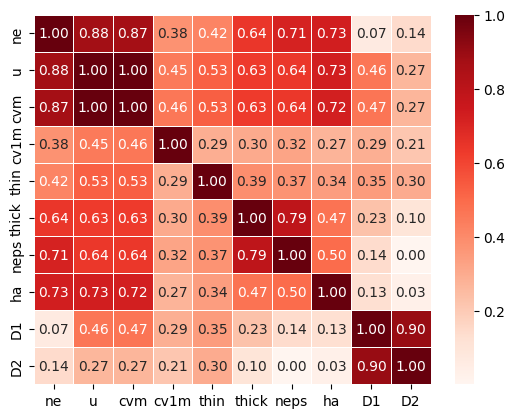

In [7]:
sns.heatmap(data.select_dtypes(include='number').corr(method='spearman').abs(), annot=True, cmap='Reds', fmt=".2f", linewidths=0.5)
plt.show()

In [8]:
qc_features = [col for col in data.select_dtypes(include='number') if col not in ['D1', 'D2']]
target_cols = ['D1', 'D2']

results = []

for x in qc_features:
    for y in target_cols:
        rho, pval = spearmanr(data[x], data[y])
        results.append({
            'QC Feature': x,
            'Target': y,
            'Spearman ρ': round(rho, 3),
            'p-value': round(pval, 4),
            'Significant': 'Ya' if pval < 0.05 else 'Tidak'
        })

spearman_df = pd.DataFrame(results)

In [9]:
spearman_df

,QC Feature,Target,Spearman ρ,p-value,Significant
0,ne,D1,-0.067,0.1587,Tidak
1,ne,D2,0.145,0.0021,Ya
2,u,D1,-0.464,0.0000,Ya
3,u,D2,-0.265,0.0000,Ya
4,cvm,D1,-0.466,0.0000,Ya
5,cvm,D2,-0.270,0.0000,Ya
6,cv1m,D1,-0.288,0.0000,Ya
7,cv1m,D2,-0.214,0.0000,Ya
8,thin,D1,-0.347,0.0000,Ya
9,thin,D2,-0.301,0.0000,Ya


Menurut Schober, Boer, dan Schwarte (2018), koefisien korelasi dapat diinterpretasikan sebagai berikut:
- 0.00 sd 0.10 - Korelasi sangat lemah (dapat diabaikan)
- 0.10 sd 0.39 - Korelasi lemah
- 0.40 sd 0.69 - Korelasi sedang
- 0.70 sd 0.89 - Korelasi kuat
- 0.90 sd 1.00 - Korelasi sangat kuat

Nilai probabilitas ambang batas p ≤ 0,05 umumnya digunakan dalam investigasi klinis untuk menunjukkan signifikansi statistik, yang mencerminkan bahwa kemungkinan hasil yang disebabkan oleh kebetulan adalah ≤5% (Di Leo & Sardanelli, 2020).

Hubungan antara parameter kualitas benang (QC) dan degradasi roller dievaluasi menggunakan korelasi Spearman. Hasil menunjukkan bahwa fitur seperti u, cvm, cv1m, dan thin memiliki korelasi negatif yang signifikan terhadap diameter roller (D1, D2). Ini mengindikasikan bahwa kualitas benang yang buruk cenderung berkorelasi dengan tingkat keausan roller yang lebih tinggi.

- Di Leo, G., & Sardanelli, F. (2020). Statistical significance: p value, 0.05 threshold, and applications to radiomics—reasons for a conservative approach. European Radiology Experimental, 4(1), 45. https://doi.org/10.1186/s41747-020-0145-y
- Schober, P., Boer, C., & Schwarte, L. A. (2018). Correlation coefficients: Appropriate use and interpretation. Anesthesia & Analgesia, 126(5), 1763–1768. https://doi.org/10.1213/ANE.0000000000002864

## Time Series Plot

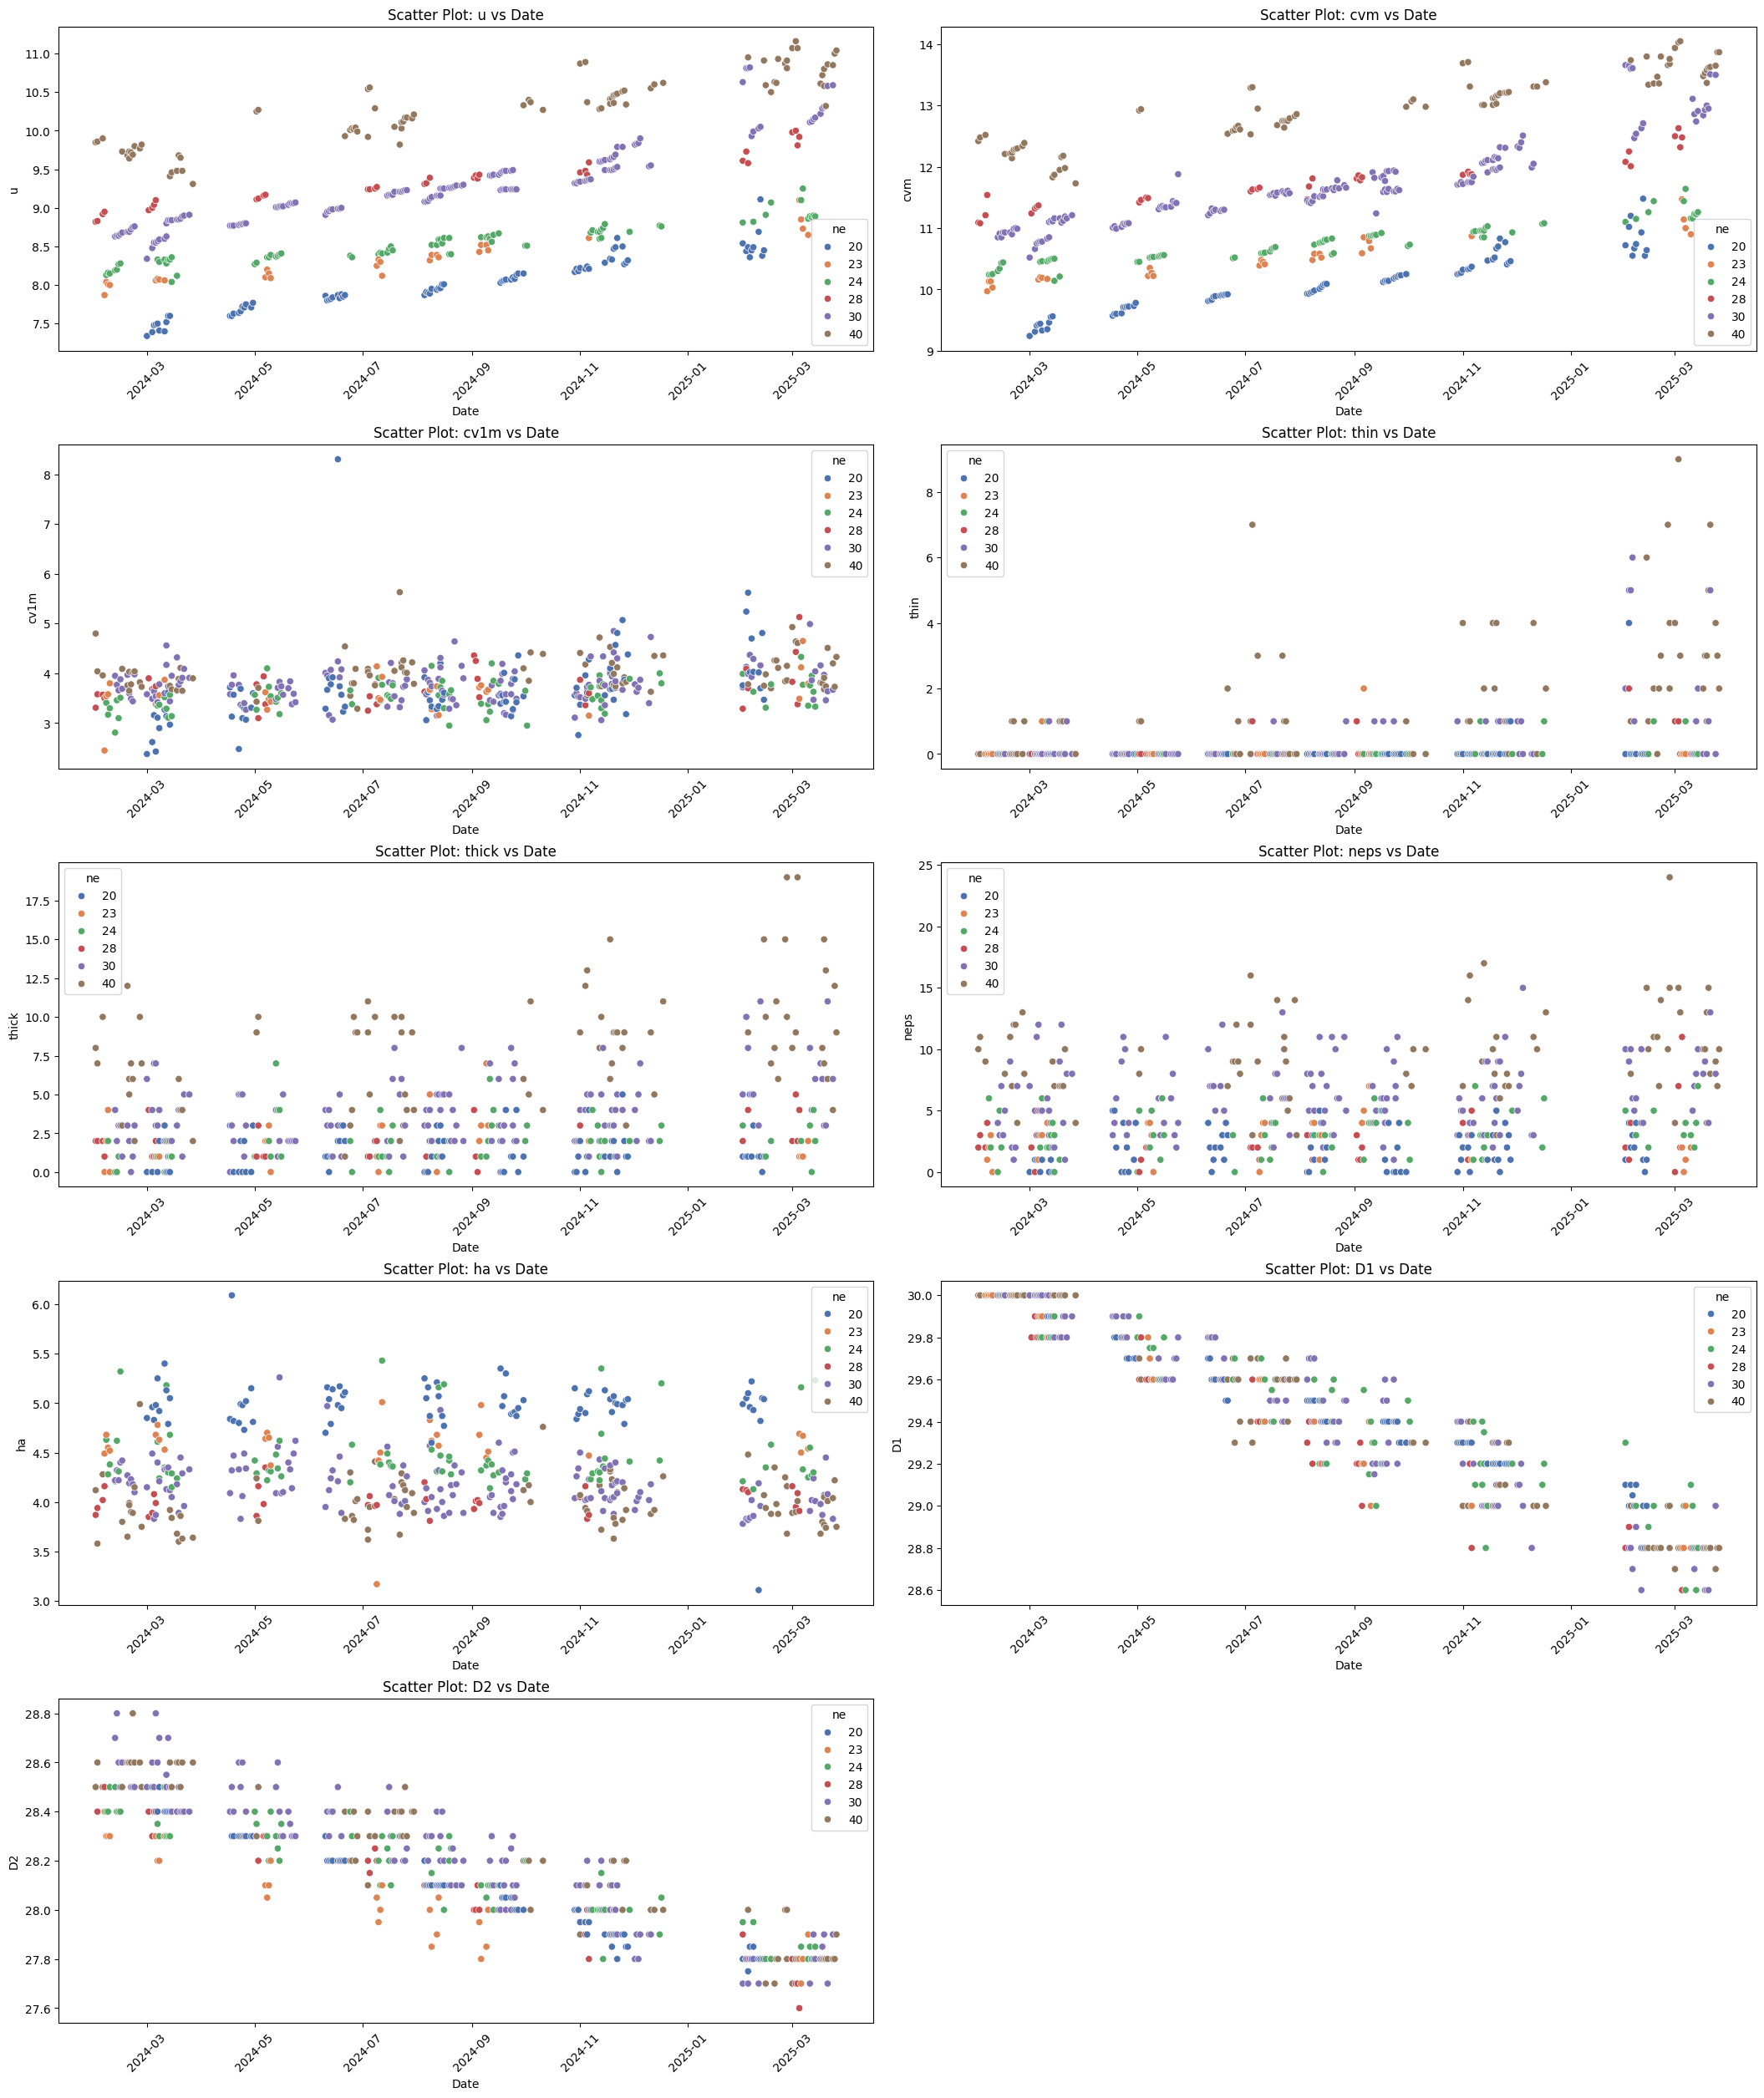

In [10]:
cols_to_plot = [col for col in data.columns if col not in ['Date', 'ne', 'RSF']]
n_cols = 2
n_rows = (len(cols_to_plot) + 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(21, n_rows * 5), constrained_layout=True)

for i, col in enumerate(cols_to_plot):
    ax = axes[i // n_cols, i % n_cols]
    sns.scatterplot(data=data, x='Date', y=col, hue='ne', palette='deep', ax=ax)
    ax.set_title(f'Scatter Plot: {col} vs Date')
    ax.tick_params(axis='x', rotation=45)

# Hapus subplot kosong jika ada
if len(cols_to_plot) % 2 != 0:
    fig.delaxes(axes[-1, -1])

plt.show()

## Rata-rata jumlah baris (tiap mesin RSF)

In [11]:
print(f'rata-rata jumlah baris per mesin (RSF) = {data.groupby('RSF').size().mean()}')

rata-rata jumlah baris per mesin (RSF) = 6.984375


Rata-rata jumlah baris hanya 6.98 (~7) baris untuk setiap mesin RSF (sejumlah 64 mesin).
Ketika data memiliki jumlah baris yang terbatas (seperti ~7 baris per unit), diperlukan teknik augmentasi data seperti interpolasi untuk menjaga validitas prediksi (Xu et al. 2023).

- Xu, P., Ji, X., Li, M., & Lu, W. (2023). Small data machine learning in materials science. npj Computational Materials, 9(1), 42. https://doi.org/10.1038/s41524-023-01000-z